EKF bearing only 2D


In [5]:
#this function computes the update (also called correction)
#step of the filter
#inputs:
#  mu: mean, 
#  sigma: covariance of the robot (x,y.theta)
#  landmarks: a structure of landmarks, we can fetch the
#            position of a landmark given its index
#            by using the tools in the library
#  observations:
#            a structure containing n observations of landmarks
#            for each observation we have
#            - the index of the landmark seen
#            - the bearing angle where we have seen the landmark (theta) w.r.t the robot
#outputs:
#  [mu, sigma]: the updated mean and covariance

function [mu, sigma] = correction_bearing_only(mu, sigma, landmarks, observations)

  % determine how many landmarks we have seen
  num_landmarks_seen = length(observations.observation);
  
  % dimension of the state in dim, in our case is fixed to 3
  state_dim = size(mu,1);

  %if I've seen no landmarks, i do nothing
  if (num_landmarks_seen==0)
    return;
  endif

  # we precompute some quantities that come in handy later on
  mu_x = mu(1);
  mu_y = mu(2);
  mu_theta = mu(3);
  c=cos(mu_theta);
  s=sin(mu_theta);
  R = [c -s; s c]; # rotation matrix
  Rt=[c,s;-s c]; # transposed rotation matrix
  Rtp=[-s,c;-c,-s]; # derivative of transposed rotation matrix

  # here in one go, we go through all landmark measurements vector
  # for each landmark, we assemble
  # the "total" measurement vector, containing all stacked measures
  # the "total" prediction vector, containing all staked predictions
  # the "total" jacobian, consisting of all jacobians of predictions stacked
  # octave allows to "Add" rows to a matrix, thus we dynamically resize them

  for i=1:num_landmarks_seen
    %retrieve info about the observed landmark
    measurement = observations.observation(i);

    z_t(end+1,:) = measurement.bearing; % where we see the landmark

    current_land = searchById(landmarks, measurement.id);
    lx = current_land.x_pose; % its absolute (true) position
    ly = current_land.y_pose;

    %where I should see that landmark
    l = [lx; ly];
    t = [mu_x; mu_y];
    bearing_prediction = [c*(lx-mu_x) + s*(ly-mu_y); -s*(lx-mu_x) + c*(ly-mu_y)];
    % t= %TODO;
    % bearing_prediction = %TODO;

    h_t(end+1,:) = bearing_prediction;

    %compute its Jacobian
    C=zeros(2,state_dim);
    C(1:2,1:2) = -Rt;
    C(1:2,state_dim) = Rtp*(l-t);
    C = (1/(lx^2+ly^2)) * [-ly, lx] * C
    %C = [%TODO ];

    C_t(end+1,:) = C;

  endfor

  %observation noise
  noise = 0.01;
  %sigma_z = %TODO;

  %Kalman gain
  %K = %TODO;

  %update mu
  %mu = %TODO;

  %update sigma
  %sigma = %TODO;

end

In [6]:
#this function implements the kalman prediction step of our localizing robot
# inputs: 
#   transition: is a data structure containing several things,
#               coming from the simulator
#               of these we are interested only in the offset
#               accessible through the "v" field of the structure
#               
#               transition.v(1)=offset x
#               transition.v(2)=offset y (ignore for a diff drive robot)
#               transition.v(3)=offset theta 
#  mu: is the mean of (x,y,theta) the previously estimated robot pose
#  sigma: is the mean of the previously estimated robot pose (3x3 matrix)

# outputs 
# [mu, sigma] are mean and covariance of the estimate after transition

function [mu, sigma] = prediction_bearing_only(mu, sigma, transition)


    u = transition.v;
    %it returns u = [ux, uy, utheta]. simply not consider uy

    %predict mu // this is our f(x,u) function in the slides
    mu = transition_model(mu, u); %TODO

    mu_x = mu(1);
    mu_y = mu(2);
    mu_theta = mu(3);

    u_x = u(1);
    u_theta = u(3);

    s = sin(mu_theta);
    c = cos(mu_theta);

    %Jacobian A
    A = [1, 0, -u_x*s; 0, 1, u_x*c; 0, 0, 1];


    %Jacobian B
    B = [c, 0; s, 0; 0, 1];

    %motion noise
    noise = 0.1;    %constant part
    v_noise = u_x^2;     %lin vel dependent part
    w_noise = u_theta^2;     %ang vel dependent part

    sigma_u = [noise^2 + v_noise, 0; 0, noise^2 + w_noise];

    %predict sigma
    sigma = A*sigma*A' + B*sigma_u*B';

end

In [7]:
% this function computes the transition of the robot after incorportating
% a movement u = [ux, uy, u_theta]
% in case of a differential drive robot, ignore uy (the case seen in the classroom)
% inputs:
%   u(1): offset on x
%   u(2): offset on y // ignore in case of differential drive
%   u(3): offset on theta

%   mu(1): x coord of robot w.r.t world
%   mu(2): y coord of robot w.r.t world
%   mu(3): angle of robot w.r.t world

% outputs:
%   mu_prime(1): x coord of robot w.r.t world, after transition
%   mu_prime(2): y coord of robot w.r.t world, after transition
%   mu_prime(3): angle of robot w.r.t world, after transition

function mu_prime = transition_model(mu, u)

    mu_prime = mu;
    mu_x = mu(1);
    mu_y = mu(2);
    ux = u(1);
    utheta = u(3);
    mu_theta = mu(3);
    c = cos(mu_theta);
    s = sin(mu_theta);

    %TODO
    mu_prime(1) = mu_x + ux*c;
    mu_prime(2) = mu_y + ux*s;
    mu_prime(3) = mu_theta + utheta;
    % mu_prime(1) = 
    % mu_prime(2) = 
    % mu_prime(3) = 

end

    loadG2o at line 50 column 6
[G2oWrapper] loading file...
#landmarks: 25 
#poses: 89 
#transitions: 88 
#observation(bearing-only): 88 
#observation(point): 0 
#laser-scan: 0 
Random initial pose: [3.535555, -3.523759, 1.585235]
C =

   0.127483  -0.051597  -0.252356

C =

   0.24161   0.13992  -1.33164

C =

   0.240431   0.063810  -1.058386

C =

   0.14397  -0.25867   0.42167

current pose: [3.535555, -3.523759, 1.585235]
C =

   0.127483  -0.051597  -0.252356

C =

   0.24161   0.13992  -1.33164

C =

   0.240431   0.063810  -1.058386

C =

   0.14397  -0.25867   0.42167

current pose: [3.535555, -3.523759, 1.585235]
C =

   0.127483  -0.051597  -0.252356

C =

   0.24161   0.13992  -1.33164

C =

   0.240431   0.063810  -1.058386

C =

   0.14397  -0.25867   0.42167

current pose: [3.535555, -3.523759, 1.585235]
C =

   0.127426  -0.051737  -0.248022

C =

   0.24176   0.13966  -1.32323

C =

   0.240501   0.063545  -1.049769

C =

   0.14369  -0.25883   0.42736

current pose: 

C =

  -0.049510  -0.104797  -1.134825

C =

   0.020074  -0.120919  -1.152586

current pose: [-7.101226, 1.390091, 5.040035]
C =

  -0.039717  -0.108886  -1.207372

C =

   0.031051  -0.118576  -1.202552

current pose: [-6.976586, 1.023394, 5.131635]
C =

   0.034652  -0.117574  -1.213252

current pose: [-6.818683, 0.669088, 5.162135]
C =

   0.038198  -0.116470  -1.224139

current pose: [-6.650049, 0.319762, 5.192435]
C =

   0.041709  -0.115260  -1.235328

C =

   0.089362  -0.071319  -0.952147

current pose: [-6.470909, -0.024295, 5.222735]
C =

   0.045182  -0.113943  -1.246806

C =

   0.091481  -0.068579  -0.978649

current pose: [-6.281427, -0.362767, 5.253035]
C =

   0.048613  -0.112522  -1.258566

C =

   0.093517  -0.065776  -1.005489

current pose: [-6.081779, -0.695344, 5.283335]
C =

   0.052000  -0.110998  -1.270594

C =

   0.095467  -0.062912  -1.032642

current pose: [-5.872147, -1.021719, 5.313635]
C =

   0.055339  -0.109371  -1.282881

C =

   0.097329  -0.059991 

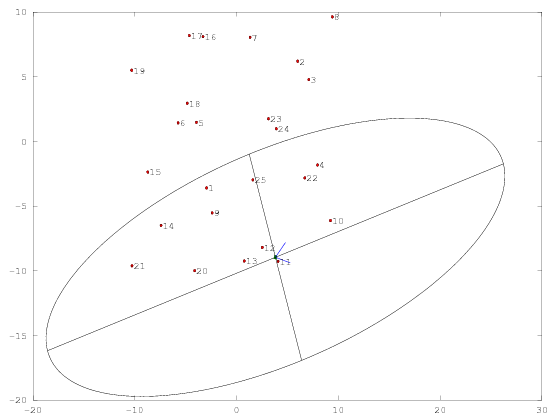

In [8]:

addpath '../'
addpath '../tools/g2o_wrapper'
addpath '../tools/visualization'
source "../tools/utilities/geometry_helpers_2d.m"

% addpath "./exercise" % uncomment this line to target the exercise
% addpath "./solution"

%load your own dataset dataset
%[landmarks, poses, transitions, observations] = loadG2o('datasets/data_bearing_only.g2o');
[landmarks, poses, transitions, observations] = loadG2o('datasets/data_bearing_only.g2o');

%% init stuff
%initial pose
mu = rand(3,1)*10-5; 
mu(3) = normalizeAngle(mu(3));
printf('Random initial pose: [%f, %f, %f]\n', mu(1),mu(2), mu(3));
fflush(stdout);

%init covariance
sigma = eye(3)*10;

%init graphics
figure(1); title("ekf-localization-bearing-only");
plot_state(landmarks, mu);


%simulation cycle
for i=1:length(transitions)

    %predict
    [mu, sigma] = prediction_bearing_only(mu, sigma, transitions(i));

    %correct
    [mu, sigma] = correction_bearing_only(mu, sigma, landmarks, observations(i));

    printf('current pose: [%f, %f, %f]\n', mu(1),mu(2), mu(3));
    % fflush(stdout);

    %plot current situation
    pause(.1);
    plot_state(landmarks, mu, sigma, observations(i));
    % hold off;

endfor

disp('mu = '), disp(mu');
